In [1]:
"""
Evolve a star cluster through a galaxy, while interacting with giant molecular clouds.

Code developed by Steven McMillan & Simon Portegies Zwart.
Code adapted from the AMUSE textbook examples: 
https://github.com/amusecode/amuse/blob/master/examples/textbook/solar_cluster_in_semilive_galaxy.py

Notebook by Francisca Concha-Ramírez
"""

from __future__ import print_function
import math
import numpy
from amuse.lab import *
from amuse.couple import bridge
from amuse.units.optparse import OptionParser
from amuse.units import quantities

from amuse.community.galaxia.interface import BarAndSpirals3D
from amuse.community.fractalcluster.interface import new_fractal_cluster_model
from amuse.ext.composition_methods import *
from matplotlib import pyplot
from prepare_figure import figure_frame, get_distinct

/home/fran/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# We will use this class for the Giant Molecular Clouds moving through the galaxy
class drift_without_gravity(object):

    def __init__(self, particles, time=0 | units.Myr):
        self.particles = particles
        self.model_time = time
        self.softening_lengths_squared = (100 | units.parsec) ** 2
        self.gravity_constant = constants.G

    def evolve_model(self, t_end):
        dt = t_end - self.model_time
        self.particles.position += self.particles.velocity * dt
        self.model_time = t_end

    def add_particles(self, p):
        self.particles.add_particles(p)

    @property
    def potential_energy(self):
        return quantities.zero

    def get_potential_at_point(self, radius, x, y, z):
        positions = self.particles.position
        result = quantities.AdaptingVectorQuantity()
        for i in range(len(x)):
            dx = x[i] - positions.x
            dy = y[i] - positions.y
            dz = z[i] - positions.z
            dr_squared = (dx * dx) + (dy * dy) + (dz * dz)
            dr = (dr_squared + self.softening_lengths_squared).sqrt()
            energy_of_this_particle = (self.particles.mass / dr).sum()
            result.append(-self.gravity_constant * energy_of_this_particle)
        return result

    def get_gravity_at_point(self, radius, x, y, z):
        positions = self.particles.position
        m1 = self.particles.mass
        result_ax = quantities.AdaptingVectorQuantity()
        result_ay = quantities.AdaptingVectorQuantity()
        result_az = quantities.AdaptingVectorQuantity()
        for i in range(len(x)):
            dx = x[i] - positions.x
            dy = y[i] - positions.y
            dz = z[i] - positions.z
            dr_squared = ((dx * dx) + (dy * dy) + (dz * dz) +
                          self.softening_lengths_squared + radius[i] ** 2)

            ax = -self.gravity_constant * (m1 * dx / dr_squared ** 1.5).sum()
            ay = -self.gravity_constant * (m1 * dy / dr_squared ** 1.5).sum()
            az = -self.gravity_constant * (m1 * dz / dr_squared ** 1.5).sum()

            result_ax.append(ax)
            result_ay.append(ay)
            result_az.append(az)
        return result_ax, result_ay, result_az

    @property
    def kinetic_energy(self):
        return (0.5 * self.particles.mass \
                * self.particles.velocity.lengths() ** 2).sum()

    def stop(self):
        return

In [3]:
# Get potential and gravity at points in the Milky Way Galaxy
class MilkyWay_galaxy(object):

    def __init__(self, Mb=1.40592e10 | units.MSun,
                 Md=8.5608e10 | units.MSun, Mh=1.07068e11 | units.MSun):
        self.Mb = Mb
        self.Md = Md
        self.Mh = Mh

    def get_potential_at_point(self, eps, x, y, z):
        r = (x ** 2 + y ** 2 + z ** 2) ** 0.5
        R = (x ** 2 + y ** 2) ** 0.5

        # bulge
        b1 = 0.3873 | units.kpc
        pot_bulge = -constants.G * self.Mb / (r ** 2 + b1 ** 2) ** 0.5

        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        pot_disk = -constants.G * self.Md / (R ** 2 + (a2 + (z ** 2 + b2 ** 2) ** 0.5) ** 2) ** 0.5

        # halo
        a3 = 12.0 | units.kpc
        cut_off = 100 | units.kpc
        d1 = r / a3
        c = 1 + (cut_off / a3) ** 1.02
        pot_halo = -constants.G * (self.Mh / a3) * d1 ** 1.02 / (1 + d1 ** 1.02) \
                   - (constants.G * self.Mh / (1.02 * a3)) \
                   * (-1.02 / c + numpy.log(c) \
                      + 1.02 / (1 + d1 ** 1.02) \
                      - numpy.log(1.0 + d1 ** 1.02))
        return 2 * (pot_bulge + pot_disk + pot_halo)  # multiply by 2 for rigid potential

    def get_gravity_at_point(self, eps, x, y, z):
        r = (x ** 2 + y ** 2 + z ** 2) ** 0.5
        R = (x ** 2 + y ** 2) ** 0.5
        # bulge
        b1 = 0.3873 | units.kpc
        force_bulge = -constants.G * self.Mb / (r ** 2 + b1 ** 2) ** 1.5
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        d = a2 + (z ** 2 + b2 ** 2) ** 0.5
        force_disk = -constants.G * self.Md / (R ** 2 + d ** 2) ** 1.5
        # halo
        a3 = 12.0 | units.kpc
        d1 = r / a3
        force_halo = -constants.G * self.Mh * d1 ** 0.02 / (a3 ** 2 * (1 + d1 ** 1.02))

        ax = force_bulge * x + force_disk * x + force_halo * x / r
        ay = force_bulge * y + force_disk * y + force_halo * y / r
        az = force_bulge * z + force_disk * d * z / (z ** 2 + b2 ** 2) ** 0.5 \
             + force_halo * z / r

        return ax, ay, az

    def vel_circ(self, r):
        z = 0 | units.kpc
        b1 = 0.3873 | units.kpc
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        a3 = 12.0 | units.kpc

        rdphi_b = constants.G * self.Mb * r ** 2 \
                  / (r ** 2 + b1 ** 2) ** 1.5
        rdphi_d = constants.G * self.Md * r ** 2 \
                  / (r ** 2 + (a2 + (z ** 2 + b2 ** 2) ** 0.5) ** 2) ** 1.5
        rdphi_h = constants.G * self.Mh * (r / a3) ** 0.02 * r \
                  / (a3 ** 2 * (1 + (r / a3) ** 1.02))

        vel_circb = rdphi_b
        vel_circd = rdphi_d
        vel_circh = rdphi_h

        return (vel_circb + vel_circd + vel_circh) ** 0.5

    def stop(self):
        return

In [4]:
def plot(stars, GMCs, N, t, R, Fd=0):
    figure = figure_frame("X [kpc]", "Y [kpc]", xsize=8, ysize=8)
    colors = get_distinct(2)

    size_stars = stars.mass / (0.1 | units.MSun)
    pyplot.scatter(stars.x.value_in(units.kpc), 
                   stars.y.value_in(units.kpc),
                   s=size_stars,  # stellar masses 
                   c=colors[0])
    
    size_gmcs = numpy.sqrt(GMCs.mass / (100 | units.MSun))
    pyplot.scatter(GMCs.x.value_in(units.kpc), 
                   GMCs.y.value_in(units.kpc),
                   s=size_gmcs,  # mass of the molecular cloud 
                   alpha=0.5, 
                   lw=0, 
                   c=colors[1])
    
    pyplot.axis("equal")
    pyplot.xlim(-10, 10)
    pyplot.ylim(-10, 10)

    figure2 = figure_frame("X [kpc]", "Y [kpc]", xsize=8, ysize=8)
    pyplot.scatter(stars.x.value_in(units.kpc), 
                   stars.y.value_in(units.kpc),
                   s=100 * stars.mass.value_in(units.MSun), # stellar masses
                   c=colors[0])
    figure2.suptitle("Cluster at the end of simulation")


    pyplot.show()

In [5]:
def evolve_cluster_in_potential(gravity, t_end, dt,
                                channels_to_framework,
                                sun=None, GMCs=None,
                                filename=False):
    Etot_init = gravity.kinetic_energy + gravity.potential_energy
    Etot_prev = Etot_init

    time = 0.0 | t_end.unit
    if filename:
        write_set_to_file(sun, filename, "hdf5", timestamp=time,
                          append_to_file=False)
        write_set_to_file(GMCs, filename, "hdf5", timestamp=time)

    x = []
    y = []
    while time < t_end:
        time += dt

        gravity.evolve_model(time)
        for ch in channels_to_framework:
            ch.copy()
        if filename:
            write_set_to_file(sun, filename, "hdf5", timestamp=time)
            write_set_to_file(GMCs, filename, "hdf5", timestamp=time)

        x.append(gravity.particles[0].x.value_in(units.kpc))
        y.append(gravity.particles[0].y.value_in(units.kpc))

        Etot_prev_se = gravity.kinetic_energy + gravity.potential_energy

        Ekin = gravity.kinetic_energy
        Epot = gravity.potential_energy
        Etot = Ekin + Epot
        print("T=", time)
        #print("E= ", Etot, "Q= ", Ekin / Epot)
        #print("dE=", (Etot_init - Etot) / Etot, "ddE=", (Etot_prev - Etot) / Etot)
        Etot_prev = Etot

    return x, y

In [6]:
def integrate_single_particle_in_potential(sun, t_end, dt):
    MWG = MilkyWay_galaxy()
    cluster_gravity = drift_without_gravity(sun)
    channel_from_gravity_to_framework \
        = cluster_gravity.particles.new_channel_to(sun)

    gravity = bridge.Bridge(use_threading=False)
    gravity.add_system(cluster_gravity, (MWG,))
    t_orb = 2 * numpy.pi * sun.position.length() / sun.velocity.length()
    gravity.timestep = min(dt, 10 | units.Myr)

    x, y = evolve_cluster_in_potential(gravity, t_end, dt,
                                       [channel_from_gravity_to_framework])
    gravity.stop()
    return x, y

In [7]:
def integrate_cluster_and_GMCs_in_potential(sun, GMCs, t_end, dt):
    MWG = MilkyWay_galaxy()
    GMC_gravity = drift_without_gravity(GMCs)
    channels = []
    channels.append(GMC_gravity.particles.new_channel_to(GMCs))

    converter = nbody_system.nbody_to_si(sun.mass.sum(),
                                         sun[0].position.length())
    cluster_gravity = BHTree(converter)
    cluster_gravity.particles.add_particles(sun)
    channels.append(cluster_gravity.particles.new_channel_to(sun))

    gravity = bridge.Bridge(use_threading=False)
    gravity.add_system(cluster_gravity, (MWG, GMC_gravity))
    gravity.add_system(GMC_gravity, (MWG,))
    gravity.timestep = min(dt, 10 | units.Myr)

    t_orb = 2 * numpy.pi * sun.position.length() / sun.velocity.length()
    gravity.timestep = min(dt, 10 | units.Myr)

    x, y = evolve_cluster_in_potential(gravity, t_end, dt,
                                       channels, sun, GMCs)
    gravity.stop()
    return x, y

In [8]:
def initialize_sun_in_milky_way():
    sun = Particles(1)
    sun.mass = 1 | units.MSun
    sun.radius = 1 | units.RSun
    sun.position = [-8400.0, 0.0, 17.0] | units.parsec
    MWG = MilkyWay_galaxy()
    vc = MWG.vel_circ(sun.position.length())
    sun.velocity = [11.352, (12.24 + vc.value_in(units.kms)), 7.41] | units.kms
    current_sun = sun.copy()
    sun.velocity *= -1
    return sun

In [9]:
def make_giant_molecular_clouds(Ngmc):
    N_thick_disk = int(0.5 * Ngmc)
    N_thin_disk = int(0.5 * Ngmc)
    converter = nbody_system.nbody_to_si(1.e+8 | units.MSun, 1.0 | units.kpc)
    
    # We will use ProtoPlanetaryDisk to create the molecular clouds
    from amuse.ext.protodisk import ProtoPlanetaryDisk
    Rin = 3.5 | units.kpc  # Inner radius
    Rout = 7.5 | units.kpc  # Outer radius
    masses = new_powerlaw_mass_distribution(N_thick_disk, alpha=-1.6,
                                            mass_min=1.0e+3 | units.MSun,
                                            mass_max=1.0e+8 | units.MSun)
    MGMCs = masses.sum()
    MWG = MilkyWay_galaxy()
    v_inner = MWG.vel_circ(Rout)
    MGalaxy = v_inner ** 2 * Rout / constants.G
    #print("Masses:", MGMCs.in_(units.MSun), MGalaxy.in_(units.MSun), MGMCs / MGalaxy)
    
    GMCs = ProtoPlanetaryDisk(len(masses), convert_nbody=converter,
                              Rmin=Rin.value_in(units.kpc),
                              Rmax=Rout.value_in(units.kpc),
                              q_out=30.0, discfraction=MGMCs / MGalaxy).result

    # Second population of GMCs
    masses = new_powerlaw_mass_distribution(len(GMCs), alpha=-1.6,
                                            mass_min=1.e+3 | units.MSun,
                                            mass_max=1.0e+8 | units.MSun)
    GMCs.mass = masses
    MGMCs = masses.sum()
    thin_disk_GMCs = ProtoPlanetaryDisk(N_thin_disk, convert_nbody=converter,
                                        Rmin=Rin.value_in(units.kpc),
                                        Rmax=2 * Rout.value_in(units.kpc),
                                        q_out=10.0, discfraction=MGMCs / MGalaxy).result
    thin_disk_GMCs.masses = masses
    GMCs.add_particles(thin_disk_GMCs)
    GMCs.velocity *= -1
    GMCs.mass = new_powerlaw_mass_distribution(len(GMCs), alpha=-1.6,
                                               mass_min=1.e+3 | units.MSun,
                                               mass_max=1.0e+8 | units.MSun)
    #print("v=", v_inner.in_(units.kms))
    #print("GMC mass=", GMCs.mass.sum().in_(units.MSun))
    for gi in range(len(GMCs)):
        r = GMCs[gi].position.length()
        vc = MWG.vel_circ(r)
        GMCs[gi].velocity = GMCs[gi].velocity * (vc / GMCs[gi].velocity.length())

    return GMCs

In [10]:
def make_new_cluster(Ncl, Rvir, W0, sun):
    masses = new_salpeter_mass_distribution(Ncl, 
                                            0.1 | units.MSun,
                                            10.0 | units.MSun)
    converter = nbody_system.nbody_to_si(masses.sum(), Rvir)
    cluster = new_king_model(len(masses), 
                             W0=3, 
                             convert_nbody=converter)
    
    # You can also try with a fractal cluster
    """cluster = new_fractal_cluster_model(N=Ncl, 
                                        fractal_dimension=1.6, 
                                        convert_nbody=converter)"""
    
    cluster.mass = masses
    eps2 = 0.25 * len(masses) ** (-2. / 3.) * Rvir ** 2
    cluster.scale_to_standard(convert_nbody=converter,
                              smoothing_length_squared=eps2)
    
    cluster.position += sun.position
    cluster.velocity += sun.velocity
    cluster.radius = 0 | units.AU
    
    return cluster

In [11]:
# Define cluster parameters
Ngmc = 1000  # Number of giant molecular clouds 
Ncl = 1000  # Number of stars in the cluster
W0 = 7.0  # Dimensionless King potential depth
Rvir = 100 | units.parsec  # Virial radius of cluster
t_end = 50 | units.Myr  # End time of simulation
n_steps = 200  # Number of diagnostics time steps

In [12]:
numpy.random.seed(111)
dt = t_end / float(n_steps)

sun = initialize_sun_in_milky_way()

print("Find birth location of the Sun.")
x, y = integrate_single_particle_in_potential(sun, t_end, dt)
sun.velocity *= -1
print("Birth location of the Sun:", sun)

GMCs = make_giant_molecular_clouds(Ngmc)
cluster = make_new_cluster(Ncl, Rvir, W0, sun)

integrate_cluster_and_GMCs_in_potential(cluster, GMCs, t_end, dt)

Find birth location of the Sun.
T= 0.25 Myr
T= 0.5 Myr
T= 0.75 Myr
T= 1.0 Myr
T= 1.25 Myr
T= 1.5 Myr
T= 1.75 Myr
T= 2.0 Myr
T= 2.25 Myr
T= 2.5 Myr
T= 2.75 Myr
T= 3.0 Myr
T= 3.25 Myr
T= 3.5 Myr
T= 3.75 Myr
T= 4.0 Myr
T= 4.25 Myr
T= 4.5 Myr
T= 4.75 Myr
T= 5.0 Myr
T= 5.25 Myr
T= 5.5 Myr
T= 5.75 Myr
T= 6.0 Myr
T= 6.25 Myr
T= 6.5 Myr
T= 6.75 Myr
T= 7.0 Myr
T= 7.25 Myr
T= 7.5 Myr
T= 7.75 Myr
T= 8.0 Myr
T= 8.25 Myr
T= 8.5 Myr
T= 8.75 Myr
T= 9.0 Myr
T= 9.25 Myr
T= 9.5 Myr
T= 9.75 Myr
T= 10.0 Myr
T= 10.25 Myr
T= 10.5 Myr
T= 10.75 Myr
T= 11.0 Myr
T= 11.25 Myr
T= 11.5 Myr
T= 11.75 Myr
T= 12.0 Myr
T= 12.25 Myr
T= 12.5 Myr
T= 12.75 Myr
T= 13.0 Myr
T= 13.25 Myr
T= 13.5 Myr
T= 13.75 Myr
T= 14.0 Myr
T= 14.25 Myr
T= 14.5 Myr
T= 14.75 Myr
T= 15.0 Myr
T= 15.25 Myr
T= 15.5 Myr
T= 15.75 Myr
T= 16.0 Myr
T= 16.25 Myr
T= 16.5 Myr
T= 16.75 Myr
T= 17.0 Myr
T= 17.25 Myr
T= 17.5 Myr
T= 17.75 Myr
T= 18.0 Myr
T= 18.25 Myr
T= 18.5 Myr
T= 18.75 Myr
T= 19.0 Myr
T= 19.25 Myr
T= 19.5 Myr
T= 19.75 Myr
T= 20.0 Myr
T= 20.2

/home/fran/amuse/src/amuse/datamodel/particles.py:302: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if numpy.issubdtype(quantity.dtype, numpy.float):


T= 0.25 Myr
T= 0.5 Myr
T= 0.75 Myr
T= 1.0 Myr
T= 1.25 Myr
T= 1.5 Myr
T= 1.75 Myr
T= 2.0 Myr
T= 2.25 Myr
T= 2.5 Myr
T= 2.75 Myr
T= 3.0 Myr
T= 3.25 Myr
T= 3.5 Myr
T= 3.75 Myr
T= 4.0 Myr
T= 4.25 Myr
T= 4.5 Myr
T= 4.75 Myr
T= 5.0 Myr
T= 5.25 Myr
T= 5.5 Myr
T= 5.75 Myr
T= 6.0 Myr
T= 6.25 Myr
T= 6.5 Myr
T= 6.75 Myr
T= 7.0 Myr
T= 7.25 Myr
T= 7.5 Myr
T= 7.75 Myr
T= 8.0 Myr
T= 8.25 Myr
T= 8.5 Myr
T= 8.75 Myr
T= 9.0 Myr
T= 9.25 Myr
T= 9.5 Myr
T= 9.75 Myr
T= 10.0 Myr
T= 10.25 Myr
T= 10.5 Myr
T= 10.75 Myr
T= 11.0 Myr
T= 11.25 Myr
T= 11.5 Myr
T= 11.75 Myr
T= 12.0 Myr
T= 12.25 Myr
T= 12.5 Myr
T= 12.75 Myr
T= 13.0 Myr
T= 13.25 Myr
T= 13.5 Myr
T= 13.75 Myr
T= 14.0 Myr
T= 14.25 Myr
T= 14.5 Myr
T= 14.75 Myr
T= 15.0 Myr
T= 15.25 Myr
T= 15.5 Myr
T= 15.75 Myr
T= 16.0 Myr
T= 16.25 Myr
T= 16.5 Myr
T= 16.75 Myr
T= 17.0 Myr
T= 17.25 Myr
T= 17.5 Myr
T= 17.75 Myr
T= 18.0 Myr
T= 18.25 Myr
T= 18.5 Myr
T= 18.75 Myr
T= 19.0 Myr
T= 19.25 Myr
T= 19.5 Myr
T= 19.75 Myr
T= 20.0 Myr
T= 20.25 Myr
T= 20.5 Myr
T= 20.75 Myr
T

([-2.8279922486735161,
  -2.8779723818941889,
  -2.9278452126385792,
  -2.9776088052739702,
  -3.0272612246663266,
  -3.0768005362210169,
  -3.1262248059246995,
  -3.1755321003883785,
  -3.2247204868916604,
  -3.2737880334282288,
  -3.3227328087525514,
  -3.3715528824278493,
  -3.4202463248753272,
  -3.4688112074246971,
  -3.5172456023659975,
  -3.5655475830027288,
  -3.6137152237063073,
  -3.6617465999718557,
  -3.7096397884753283,
  -3.7573928671319847,
  -3.8050039151562114,
  -3.8524710131226909,
  -3.8997922430289202,
  -3.9469656883590756,
  -3.9939894341492179,
  -4.0408615670538293,
  -4.0875801754136694,
  -4.1341433493249475,
  -4.1805491807097788,
  -4.2267957633879236,
  -4.272881193149777,
  -4.3188035678305914,
  -4.364560987385901,
  -4.4101515539681273,
  -4.4555733720043209,
  -4.500824548275026,
  -4.5459031919942028,
  -4.5908074148902038,
  -4.6355353312877243,
  -4.6800850581907172,
  -4.7244547153662113,
  -4.7686424254289799,
  -4.8126463139270212,
  -4.856464509

AttributeError: 'tuple' object has no attribute 'suptitle'

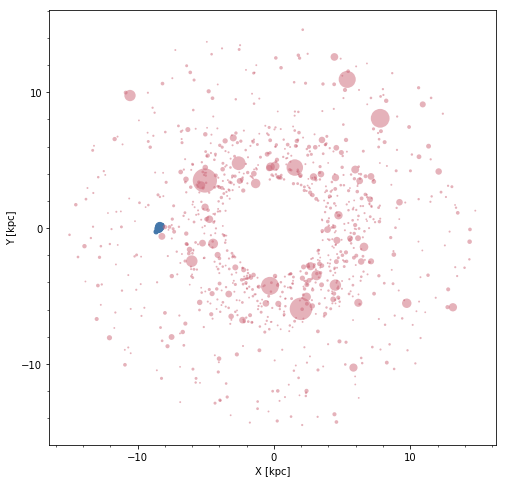

In [13]:
plot(cluster, GMCs, Ncl, t_end, Rvir)